# HW08: Making Python faster

This homework provides practice in making Python code faster. Note that we start with functions that already use idiomatic `numpy` (which are about two orders of magnitude faster than the pure Python versions).

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import numba
import pandas as pd
from numba import jit, float64
from sklearn.datasets import make_blobs
%load_ext cython

**Functions to optimize**

In [2]:
def logistic(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

def gd(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

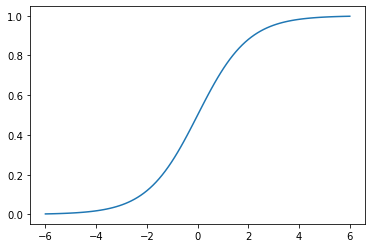

In [3]:
x = np.linspace(-6, 6, 100)
plt.plot(x, logistic(x))
pass

**Data set for classification**

In [4]:
n = 10000
p = 2
X, y = make_blobs(n_samples=n, n_features=p, centers=2, cluster_std=1.05, random_state=23)
X = np.c_[np.ones(len(X)), X]
y = y.astype('float')

**Using gradient descent for classification by logistic regression**

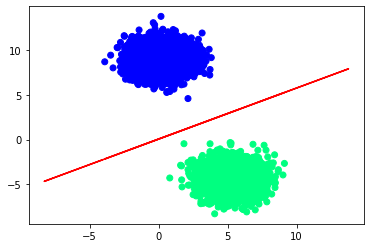

In [5]:
# initial parameters
niter = 1000
α = 0.01
β = np.zeros(p+1)

# call gradient descent
β = gd(X, y, β, α, niter)

# assign labels to points based on prediction
y_pred = logistic(X @ β)
labels = y_pred > 0.5

# calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass

**1**. Rewrite the `logistic` function so it only makes one `np.exp` call. Compare the time of both versions with the input x given below using the `@timeit` magic. (10 points)

In [6]:
# Define function
def logistic2(x):
    """Logistic function with only one np.exp call"""
    return 1 / (1 + np.exp(-x))

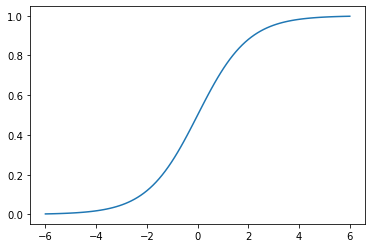

In [7]:
# Prove that function works
x = np.linspace(-6, 6, 100)
plt.plot(x, logistic2(x))
pass

In [8]:
# Given quantities
np.random.seed(123)
n = int(1e7)
x = np.random.normal(0, 1, n)

In [9]:
%%timeit
logistic(x)

516 ms ± 5.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
logistic2(x)

328 ms ± 2.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


*We see that the newly defined logistic function (with only one call to `np.exp`) takes about 60% as long to run on a vector of 10,000,000 values (compared to the original function)*

**2**. (20 points) Use `numba` to compile the gradient descent function. 

- Use the `@vectorize` decorator to create a ufunc version of the logistic function and call this `logistic_numba_cpu` with function signatures of `float64(float64)`. Create another function called `logistic_numba_parallel` by giving an extra argument to the decorator of `target=parallel` (5 points)
- For each function, check that the answers are the same as with the original logistic function using  `np.testing.assert_array_almost_equal`. Use `%timeit` to compare the three logistic functions (5 points)
- Now use `@jit` to create a JIT_compiled version of the `logistic` and `gd` functions, calling them `logistic_numba` and `gd_numba`. Provide appropriate function signatures to the decorator in each case. (5 points)
- Compare the two gradient descent functions `gd` and `gd_numba` for correctness and performance. (5 points)

*First, we define the two functions described in the first bullet of the exercise*

In [11]:
@numba.vectorize([float64(float64)])
def logistic_numba_cpu(x):
    """Vectorized numba logistic function"""
    return 1 / (1 + np.exp(-x))

In [12]:
@numba.vectorize([float64(float64)],
                target = "parallel")
def logistic_numba_parallel(x):
    """Vectorized, parallel numba logistic function"""
    return 1 / (1 + np.exp(-x))

*Next, we test that all three logistic functions defined so far (excluding the original one provided) produce the same results*

In [13]:
# Calculate output from all 3 logistic functions
res1 = logistic2(x)
res2 = logistic_numba_cpu(x)
res3 = logistic_numba_parallel(x)

# Run pairwise comparisons
np.testing.assert_array_almost_equal(res1, res2)
np.testing.assert_array_almost_equal(res1, res3)
np.testing.assert_array_almost_equal(res2, res3)

*Since the `np.testing.assert_array_almost_equal()` function does not raise an error for every pairwise combination of outcomes, we can be confident that the function outputs are the same*

*We are also interesting in timing these three logistic functions*

In [14]:
# Initialize dataframe
df = pd.DataFrame(dict(Seconds = [0, 0, 0]), index = ["Original", "Numba CPU", "Numba Parallel"])

# Calculate run times
original = %timeit -o logistic2(x)
cpu = %timeit -o logistic_numba_cpu(x)
parallel = %timeit -o logistic_numba_parallel(x)

# Fill in dataframe, and display
df.iloc[0, 0] = original.average
df.iloc[1, 0] = cpu.average
df.iloc[2, 0] = parallel.average
df

3.51 s ± 31.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
933 ms ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
56.4 ms ± 3.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


,Seconds
Original,3.506665
Numba CPU,0.932621
Numba Parallel,0.056444


*Next, we create logistic and gradient descent functions using jit. We'll ensure that the results of these functions match the results that we've seen previously, and we'll time the new gradient descent function (relative to the original)*

In [15]:
@jit('double[:](double[:])')
def logistic_numba(x):
    """Logistic function with jit"""
    return 1 / (1 + np.exp(-x))

In [16]:
# Test logistic_numba
res4 = logistic_numba(x)
np.testing.assert_array_almost_equal(res1, res4)

*The new logistic function (with numba) appears to agree in result with the previous versions of the logistic function*

In [17]:
@jit('double[:](double[:,:], double[:], double[:], double, double)')
def gd_numba(X, y, beta, alpha, niter):
    """Gradient descent algorihtm with jit"""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic_numba(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

<ipython-input-17-fb78198835e4>:7: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, A))
  y_pred = logistic_numba(X @ beta)
<ipython-input-17-fb78198835e4>:9: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  grad = Xt @ epsilon / n
/opt/conda/lib/python3.6/site-packages/numba/typing/npydecl.py:958: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/opt/conda/lib/python3.6/site-packages/numba/typing/npydecl.py:958: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  warnings.warn(NumbaPerformanceWarning(msg))


In [18]:
# Test different gradient descent functions
β1 = gd(X, y, β, α, niter)
β2 = gd_numba(X, y, β, α, niter)

# Check for equality
np.testing.assert_array_almost_equal(β1, β2)

*The two gradient descent functions appear to agree in result*

In [19]:
%%timeit
gd(X, y, β, α, niter)

1.18 s ± 176 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%timeit
gd_numba(X, y, β, α, niter)

686 ms ± 127 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


*We see that the numba version of the gradient descent function takes about 55% as long to run for the given X, y, $\beta, \alpha$, and niter values given in the introduction to the assignment*

**3**. (30 points) Use `cython` to compile the gradient descent function. 

- Cythonize the logistic function as `logistic_cython`. Use the `--annotate` argument to the `cython` magic function to find slow regions. Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (10 points)
- Now cythonize the gd function as `gd_cython`. This function should use of the cythonized `logistic_cython` as a C function call.  Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (20 points)

Hints: 

- Give static types to all variables
- Know how to use `def`, `cdef` and `cpdef`
- Use Typed MemoryViews
- Find out how to transpose a Typed MemoryView to store the transpose of X
- Typed MemoryVeiws are not `numpy` arrays - you often have to write explicit loops to operate on them
- Use the cython boundscheck, wraparound, and cdivision operators

*First, we cythonize the logistic function and compare accuracy / performance*

In [21]:
%%cython

import cython
import numpy as np
from libc.math cimport exp

@cython.cdivision
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef logistic_cython(double[:] x, double[:] res):
    """Cython logistic function"""
    
    # Define constant for iteration in for loop
    cdef int i
    
    # Loop through elements of x
    for i in range(x.shape[0]):
        res[i] = 1 / (1 + exp(-x[i]))
    
    # Return result
    return res

In [22]:
# Compare accuracy
res5 = np.zeros(shape = x.shape[0])
logistic_cython(x, res5)
np.testing.assert_array_almost_equal(res1, res5)

*The new logistic function (with Cython) appears to agree in result with the previous versions of the logistic function*

*Next, we compare performance and see that the Cython version is comparable to the version in which we used jit (but a little slower than Numba CPU)*

In [23]:
# Initialize new dataframe rows for jit and cython versions of logistic function
df2 = pd.DataFrame(dict(Seconds = [0, 0]), index = ["JIT", "Cython"])

# Calculate run times
jit = %timeit -o logistic_numba(x)
cython = %timeit -o logistic_cython(x, np.zeros(shape = x.shape[0]))

# Fill in dataframe
df2.iloc[0, 0] = jit.average
df2.iloc[1, 0] = cython.average

# Append df2 to df, and display
df.append(df2)

273 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
279 ms ± 822 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


,Seconds
Original,3.506665
Numba CPU,0.932621
Numba Parallel,0.056444
JIT,0.273031
Cython,0.279203


*Next, we cythonize the gradient descent function*

**4**. (40 points) Wrapping modules in C++.

Rewrite the `logistic` and `gd` functions in C++, using `pybind11` to create Python wrappers.  Compare accuracy and performance as usual. Replicate the plotted example using the C++ wrapped functions for `logistic` and `gd`

- Writing a vectorized `logistic` function callable from both C++ and Python (10 points)
- Writing the `gd` function callable from Python (25 points)
- Checking accuracy, benchmarking and creating diagnostic plots (5 points)

Hints:

- Use the C++ `Eigen` library to do vector and matrix operations (include path is `../notebooks/eigen3`)
- When calling the exponential function, you have to use `exp(m.array())` instead of `exp(m)` if you use an Eigen dynamic template.
- Use `cppimport` to simplify the wrapping for Python
- See [`pybind11` docs](http://pybind11.readthedocs.io/en/latest/index.html)
- See my [examples](http://people.duke.edu/~ccc14/cspy/18G_C++_Python_pybind11.html#) for help